# 1. Install Dependencies and Setup

In [2]:
%pip install opencv-python matplotlib




Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/adityashukla/Downloads/IrisDetection-main/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.la

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/adityashukla/Downloads/IrisDetection-main/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.la

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())
print(tf.config.list_physical_devices())

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

NameError: name 'tf' is not defined

# 2. Load Data

### 2.1 Load Images

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return np.array(label['keypoints'], dtype=np.float32)

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
train_labels = train_labels.map(lambda x: tf.ensure_shape(x, [4]))


In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
test_labels = test_labels.map(lambda x: tf.ensure_shape(x, [4]))


In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
val_labels = val_labels.map(lambda x: tf.ensure_shape(x, [4]))

### 2.3. Combine Labels and Images

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(4)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 2.4 View Samples

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

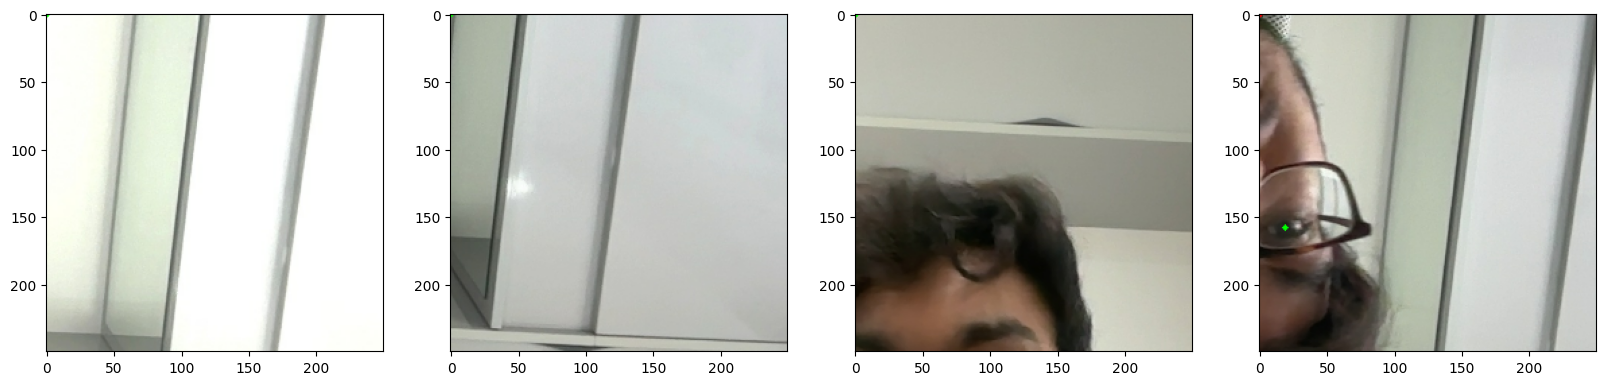

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][idx]
    
    # Convert image to uint8 for OpenCV drawing
    img_to_draw = (sample_image * 255).astype(np.uint8).copy()
    
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(img_to_draw)

# 3. Build Model

### 3.1 Create Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet50V2

In [ ]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet50V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 4)          

### 3.2 Setup Losses and Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(4, 250, 250, 3)

In [ ]:
scores = model.predict(X)

2025-07-05 12:59:08.756216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


In [ ]:
scores

array([[-0.5265845 , -0.07031409,  0.6188143 ,  0.08574632],
       [-0.70154065, -0.25458387,  1.4559052 ,  0.51410556],
       [-0.30661687, -0.974467  ,  1.779768  ,  0.24975072],
       [-0.04980936, -0.7915157 ,  0.6602899 ,  0.89765644]],
      dtype=float32)

### 3.4 Train the Model

In [ ]:
# Train for 100 epochs

hist = model.fit(train, epochs=100, validation_data=val)

NameError: name 'model' is not defined

In [ ]:
model.save("iris_estimation_model_new.h5")
model.evaluate(test)

135/135 [==============================] - 15s 101ms/step - loss: 0.0049


0.004850578960031271

# 4. Review Performance

### 4.1 View Loss Plots

In [ ]:
hist.history

{'loss': [0.02454342693090439,
  0.01645183004438877,
  0.009765206836163998,
  0.007172791287302971,
  0.005977405235171318,
  0.006337285041809082,
  0.0046701994724571705,
  0.003404723946005106,
  0.004544335883110762,
  0.002017224906012416,
  0.003426080569624901,
  0.001560134463943541,
  0.001739035127684474,
  0.001439462648704648,
  0.0008669347153045237,
  0.0005108695477247238,
  0.0006660952349193394,
  0.00042799158836714923,
  0.0008072836208157241,
  0.00024207386013586074,
  0.0002488357713446021,
  0.00019940015044994652,
  0.00024629797553643584,
  0.0001812751143006608,
  0.00013478090113494545,
  0.00013482167560141534,
  0.00022202670515980572,
  0.00021562898473348469,
  0.00025590191944502294,
  8.918447565520182e-05,
  6.50060610496439e-05,
  6.891752127557993e-05,
  7.447181269526482e-05,
  7.572320464532822e-05,
  6.838575791334733e-05,
  6.70832087052986e-05,
  6.810540071455762e-05,
  8.076139783952385e-05,
  5.7719749747775495e-05,
  4.5064760342938825e-05

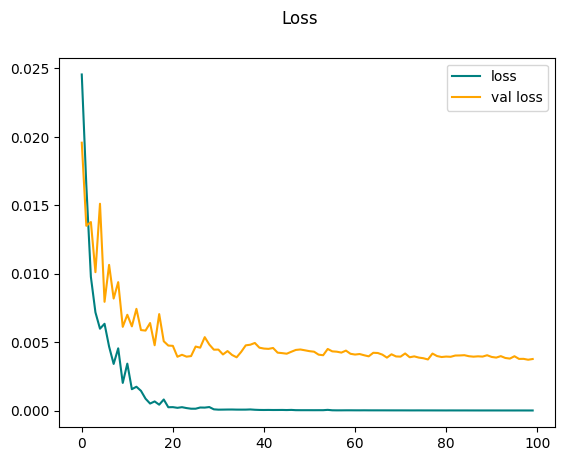

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 1s 587ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


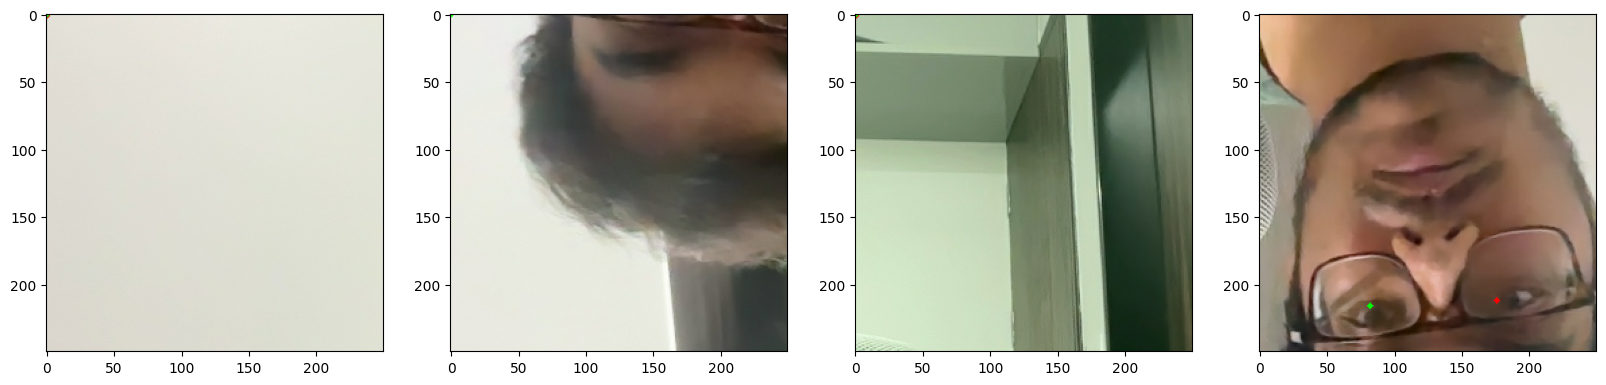

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    # Make a writable copy
    img_to_draw = sample_image.copy()
    
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(img_to_draw)

### 4.3. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('eyetrackerresnet.h5')

In [ ]:
model = load_model('eyetrackerresnet.h5')

In [ ]:
model.predict(test_sample[0])

2025-07-05 00:14:41.225404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


array([[2.32343003e-03, 3.80879641e-03, 3.34994495e-03, 3.49335000e-03],
       [2.70626694e-03, 3.99433076e-03, 2.58840621e-03, 2.85864249e-03],
       [2.50297040e-03, 4.23368812e-03, 2.79777497e-03, 3.21445987e-03],
       [5.96882552e-02, 5.74469566e-03, 5.23419321e-01, 3.56450044e-02],
       [1.13068633e-02, 4.73506749e-04, 6.89058185e-01, 3.07528943e-01],
       [7.44977355e-01, 2.60086358e-01, 2.84165516e-03, 1.26936175e-02],
       [2.35819072e-03, 4.94019687e-03, 2.48174369e-03, 3.58434021e-03],
       [2.28977948e-03, 4.14091349e-03, 2.86005810e-03, 3.44036892e-03]],
      dtype=float32)

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2025-07-05 00:14:50.005 Python[29811:6751323] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


1/1 [==============================] - 0s 37ms/step


2025-07-05 00:14:55.485 Python[29811:6751323] +[IMKClient subclass]: chose IMKClient_Modern
2025-07-05 00:14:55.485 Python[29811:6751323] +[IMKInputSession subclass]: chose IMKInputSession_Modern


1/1 [==============================] - 0s 17ms/step
